In [118]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [3]:
ROI = 'Unknown_19_F'
PVAL = 0.05

# load in per-image psth
sig = dat[dat['p_value'] < PVAL]
df = sig[sig['roi'] == ROI]
X = np.stack(df['img_psth'].to_numpy())
print(f'Loaded unit-level data for each image. Shape:', X.shape, '---> (units, time points, images)')

# center the data per unit and per image
X_centered = X - X.mean(axis=1, keepdims=True)
print('Centered shape:', X_centered.shape)

# concatenate each image's time series
# Xsub = X_centered.reshape(X_centered.shape[0], -1) 

# average across images
# Xsub = np.mean(X_centered, axis=2)

# look only at localizer image responses
Xsub = X_centered[:, :, 1000:]

print('Final data shape:', Xsub.shape)
# stagger for DMD
# X_ = Xsub[:, :-1]
# Y_ = Xsub[:, 1:]

Loaded unit-level data for each image. Shape: (261, 450, 1072) ---> (units, time points, images)
Centered shape: (261, 450, 1072)
Final data shape: (261, 450, 72)


24


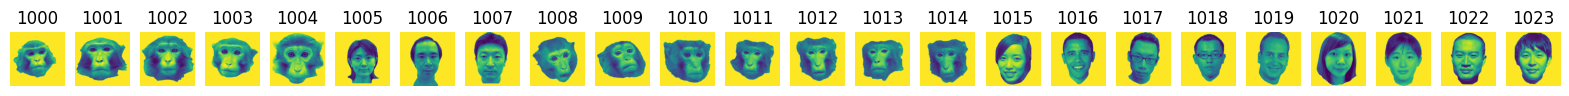

24


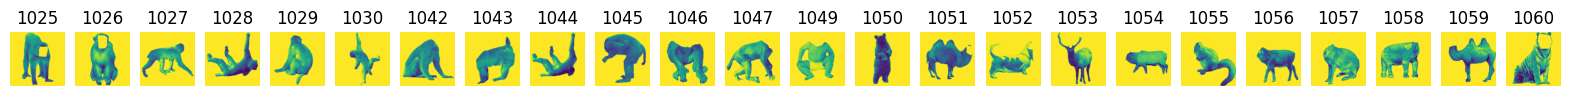

24


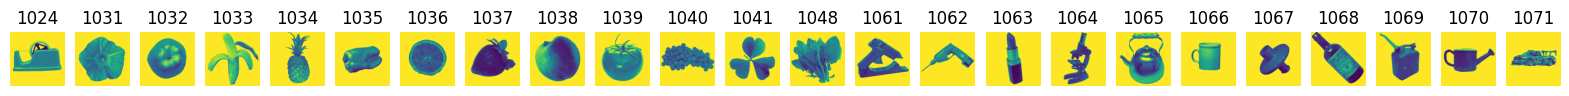

(450, 24)


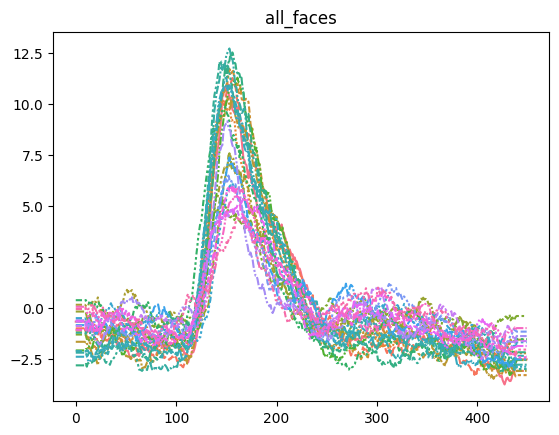

(450, 24)


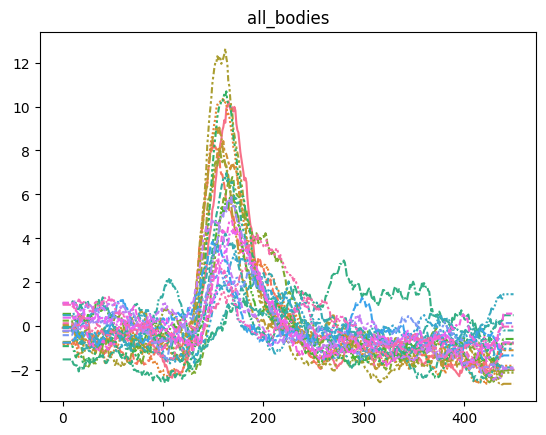

(450, 24)


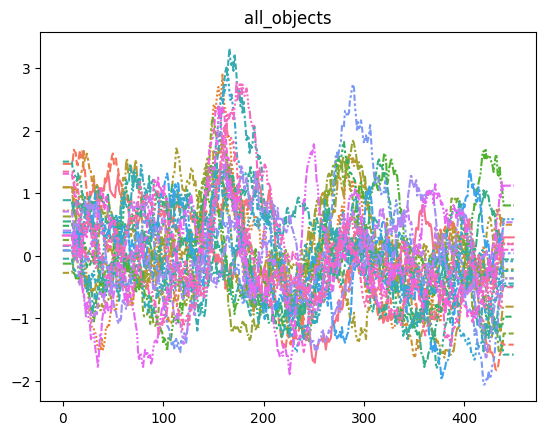

In [177]:
img_sets = {
    "all_faces":  np.arange(1000, 1024),
    "all_bodies": np.concatenate([
        np.arange(1025, 1031),
        np.arange(1042, 1048),
        np.arange(1049, 1061)
    ]),
    "all_objects": np.concatenate([
        np.arange(1024,1025),
        np.arange(1031, 1042),
        np.arange(1048,1049),
        np.arange(1061, 1072)
    ])
}

IMG_DIR = '../../datasets/NNN/NSD1000_LOC/'


for cat, indices in img_sets.items():
    print(len(indices))
    fig,axes = plt.subplots(1, min(len(indices), 33), figsize=(20,5))
    axes = axes.ravel()
    for idx, imgid in enumerate(indices):
        subpath = f'MFOB{(imgid-1000+1):03d}.bmp'
    
        ax = axes[idx]
        img_pth = os.path.join(IMG_DIR, subpath)
        img = mpimg.imread(img_pth)
        ax.imshow(img)
        ax.set_title(imgid)
        ax.set_axis_off()
    plt.show()

# build per-category local index arrays
cat_local = {
    k: (v - 1000)[(v - 1000 >= 0) & (v - 1000 < X.shape[2])]
    for k, v in img_sets.items()
}
cat_local

for cat, indices in img_sets.items():
    Xs = X_centered[:, :, indices].mean(axis=0)
    print(Xs.shape)
    fig,ax = plt.subplots(1,1)
    sns.lineplot(Xs, ax=ax, legend=False)
    ax.set_title(cat)
    plt.show()

In [105]:
def dmd(X_, Y_, r):
    # X: (units, time)
    # X_ = X[:, :-1]
    # Y_ = X[:,  1:]
    U,S,Vt = np.linalg.svd(X_, full_matrices=False)
    U_r, S_r, V_r = U[:,:r], S[:r], Vt[:r,:].T
    Atilde = (U_r.T @ Y_) @ (V_r * (1.0/S_r))
    lam, W = np.linalg.eig(Atilde)
    Phi = Y_ @ (V_r * (1.0/S_r)) @ W
    return lam, Phi, (U_r,S_r,V_r,Atilde)

def delay_embed(Z, L):
    # Z: (k, T), returns (k*L, T-L+1) stacked windows within an image
    T = Z.shape[1]
    return np.vstack([Z[:, s:T-L+s+1] for s in range(L)])

def mode_amplitudes(Phi, W_img):
    # initial coefficients for image i (at the first embedded time)
    return np.linalg.lstsq(Phi, W_img[:, 0], rcond=None)[0]

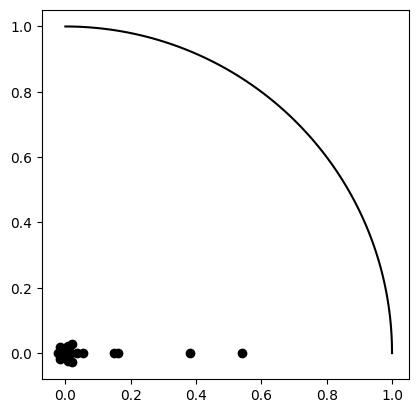

In [80]:
# ALL IMAGE (NSD) DMD
Xsub = X_centered[:, :, :1000]
Xi = Xsub.reshape(Xsub.shape[0], -1) 
lam, Phi, _ = dmd(Xi, r=20)

fig,ax = plt.subplots(1,1)

# plot unit circle
p = np.linspace(0, np.pi/2, 100)
ax.plot(np.cos(p), np.sin(p), c="k")

ax.scatter(lam.real, lam.imag, color='black')
ax.set_aspect("equal")
plt.show()

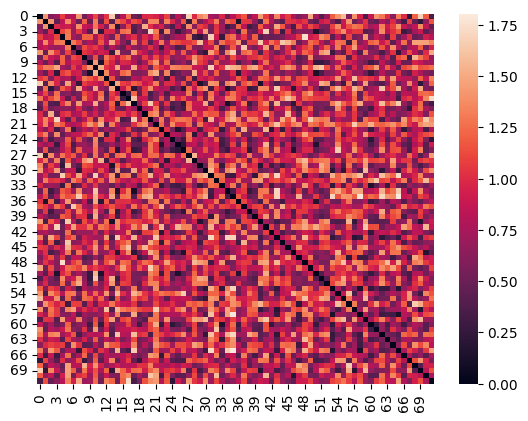

In [167]:
# # PER IMAGE DMD for LOCALIZER IMAGES
# fig,ax = plt.subplots(1,1)
# for i in range(72):
#     Xi = Xsub[:, :, i]
#     X_ = Xi[:, :-1]; Y_ = Xi[:,  1:]
#     lam, Phi, _ = dmd(X_, Y_, r=20)
#     ax.scatter(lam.real, lam.imag, alpha=0.5)

# Xi = Xsub.reshape(Xsub.shape[0], -1) 
# X_ = Xi[:, :-1]; Y_ = Xi[:,  1:]
# lam, Phi, _ = dmd(X_, Y_, r=20)
# ax.scatter(lam.real, lam.imag, color='black')
# plt.show()

# =================================== SHARED BASIS ===========================
k = 40 # PCA components
L = 7 # window size
r = 20 # DMD modes

Xc = X_centered[:, :, 1000:]
Xpool = Xc.reshape(Xc.shape[0], -1)          # (units, time*images)

# dim reduction using PCA
U, S, Vt = np.linalg.svd(Xpool, full_matrices=False)
P = U[:, :k].T

W_list = []
for i in range(Xc.shape[2]):
    Zi = P @ Xc[:, :, i]                      # (k, T)
    Wi = delay_embed(Zi, L)                   # (k*L, T_eff)
    W_list.append(Wi)

Wpool = np.concatenate(W_list, axis=1)        # (k*L, sum T_eff)
X_, Y_ = Wpool[:, :-1], Wpool[:, 1:]

# shared-basis DMD
lam, Phi, cache = dmd(X_, Y_, r) 

# look at shared mode amplitudes across images
B = np.stack([mode_amplitudes(Phi, Wi) for Wi in W_list], axis=1)  # (r, 72)

F = np.abs(B).T        # (images × r)
D = squareform(pdist(F, metric='correlation'))
sns.heatmap(D)

# category centroids in amplitude space
def centroid(F, indices):
    mask = np.isin(range(72), indices)
    return np.median(F[mask], axis=0), np.where(mask)[0]

centroids = {}
members = {}
for name, ids in cat_local.items():
    c, m = centroid(F, ids)
    centroids[name] = c
    members[name] = m

cat_lams = {}
for name, ids in cat_local.items():
    if len(ids) == 0: 
        continue
    W_cat = np.concatenate([W_list[np.where(local_idx == i)[0][0]] for i in ids], axis=1)
    Xc_, Yc_ = W_cat[:, :-1], W_cat[:, 1:]
    lam_c, _, _ = dmd(Xc_, Yc_, r)
    cat_lams[name] = lam_c

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


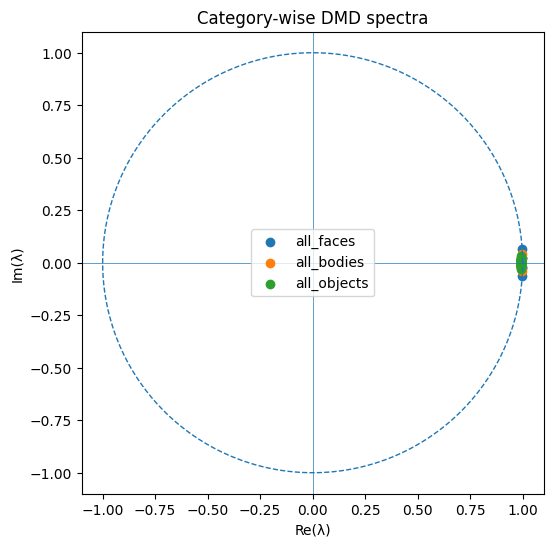

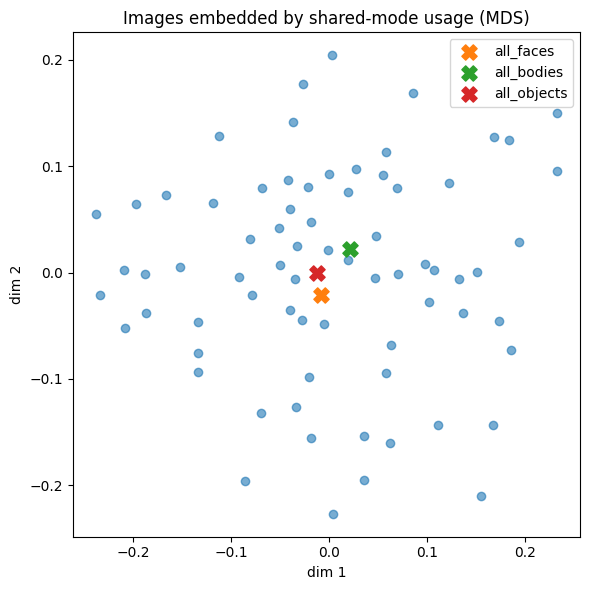

In [168]:
fig, ax = plt.subplots(figsize=(6,6))
theta = np.linspace(0, 2*np.pi, 400)
ax.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=1)  # unit circle
for name, lam in cat_lams.items():
    ax.scatter(lam.real, lam.imag, label=name)
ax.axhline(0, linewidth=0.5); ax.axvline(0, linewidth=0.5)
ax.set_aspect("equal", "box"); ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")
ax.set_title("Category-wise DMD spectra")
ax.legend()

plt.figure(figsize=(6,6))
# 2) Category structure in shared amplitude space (centroids + images via MDS)
D = cosine_distances(F)
Z = MDS(n_components=2, dissimilarity="precomputed", random_state=0).fit_transform(D)
plt.scatter(Z[:,0], Z[:,1], alpha=0.6)
for name, idxs in members.items():
    cx, cy = Z[idxs].mean(axis=0)
    plt.scatter([cx],[cy], marker="X", s=120, label=name)
plt.title("Images embedded by shared-mode usage (MDS)")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.legend()
plt.tight_layout()
plt.show()

In [161]:
all_ids = np.concatenate(list(img_sets.values()))
# Suppose X is ordered by global IDs 1000..1071; map global IDs to local indices:
# local index = id - 1000
local_idx = all_ids - 1000
local_idx = local_idx[(local_idx >= 0) & (local_idx < X.shape[2])]
local_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 42, 43, 44, 45,
       46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 24, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71])

In [ ]:
# MEAN RESPONSE SVD
U, S, Vh = np.linalg.svd(X_, full_matrices=False)
print('SVD shapes:', U.shape, S.shape, Vh.shape)

# choose r that explains 95% of energy
energy = (S**2).cumsum() / (S**2).sum()
r = np.searchsorted(energy, 0.95) + 1   # 95% example

# Truncate
U_r = U[:, :r]          # (m, r)
S_r = S[:r]             # (r,)
V_r = Vh[:r, :].T       # (n, r)  <-- columns of V

print('Truncated:', U_r.shape, S_r.shape, V_r.shape)

# Atilde = U_r^T Y V_r S_r^{-1}
Atilde = (U_r.T @ Y_) @ (V_r * (1.0 / S_r))   # column-wise divide by S_r

# Eigenvalues (and optionally modes)
eigvals, W = np.linalg.eig(Atilde)
Phi = Y_ @ (V_r * (1.0 / S_r)) @ W   

# plot on unit circle
plt.scatter(eigvals.real, eigvals.imag, s=20)
th = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(th), np.sin(th), 'k--', lw=1)
plt.axhline(0, lw=0.5); plt.axvline(0, lw=0.5)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('Re(λ)'); plt.ylabel('Im(λ)')
plt.title('DMD eigenvalues')
plt.show()

# visualize the modes
sns.heatmap(np.real(Phi))
plt.xlabel('Mode'); plt.ylabel('Neuron')
plt.title('Spatial pattern of DMD modes')

# I DONT REALLY SEE ANYTHING?

In [15]:
# PER IMAGE DMD
r = 20
dt = 1/1000

LAM, FREQ = [], []
for imgid in range(72):
    Xi = Xsub[:, :, imgid]
    
    # PCA on data
    k = 50
    U,S,Vt = np.linalg.svd(Xi, full_matrices=False)
    
    Xiproj = U[:,:k] @ np.diag(S[:k]) @ Vt[:k]
    # print(Xi.shape, Xiproj.shape)
    
    # DMD with r modes
    lam, Phi, _ = dmd(Xiproj, r)
    
    # transform parameters into continuous variables
    omega = np.log(lam)/dt
    freq = np.imag(omega)/(2*np.pi)
    decay = np.real(omega)

    LAM.append(lam)
    FREQ.append(freq)


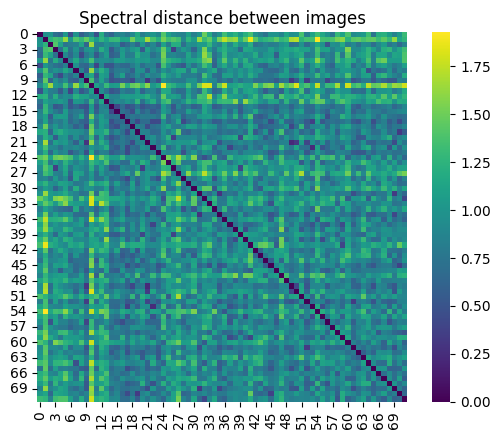

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


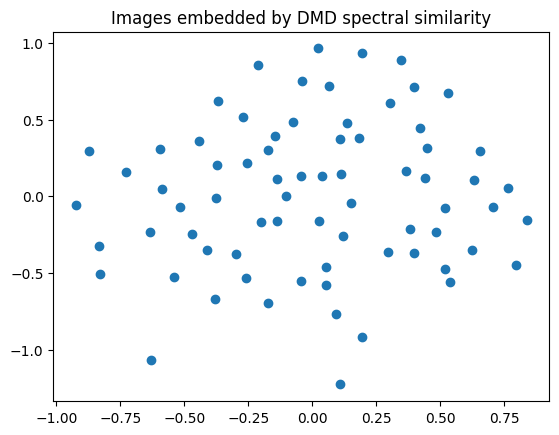

In [23]:
# VISUALISE MODE SIMILARITY ACROSS IMAGES

I = len(LAM)
D = np.zeros((I,I))
for i in range(I):
    fi = np.sort(FREQ[i])
    wi = None # if b_list is None else np.abs(b_list[i])/np.sum(np.abs(b_list[i]))
    for j in range(i+1, I):
        fj = np.sort(FREQ[j])
        wj = None # if b_list is None else np.abs(b_list[j])/np.sum(np.abs(b_list[j]))
        D[i,j] = D[j,i] = wasserstein_distance(fi, fj, u_weights=wi, v_weights=wj)

sns.heatmap(D, cmap="viridis", square=True)
plt.title("Spectral distance between images"); plt.show()

embed = MDS(n_components=2, dissimilarity='precomputed', random_state=0).fit_transform(D)
plt.scatter(embed[:,0], embed[:,1])
# add labels if you have categories
plt.title("Images embedded by DMD spectral similarity"); plt.show()